In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

import re
import string
import spacy
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.chunk import ne_chunk
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
import gensim.corpora as corpora
from gensim import matutils, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

plt.style.use("seaborn-dark")

In [3]:
df = pd.read_csv('complaints_nlp.csv')

In [4]:
df.head()

,date_received,product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,zip_code,tags,company_response_to_consumer,timely_response?,consumer_disputed?,complaints,complaints_tagged
0,08/30/19,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,"In XXXX, I started receiving mail and phone ca...",None,Resurgent Capital Services L.P.,62205,None,Closed with explanation,Yes,NaN,"['mail', 'phone', 'debt', 'information', 'seve...","[('mail', 'NN'), ('phone', 'NN'), ('debt', 'NN..."
1,06/21/19,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,In XX/XX/2019 I received a phone call from XXX...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,60643,None,Closed with explanation,Yes,NaN,"['receive', 'phone', 'handle', 'case', 'hung',...","[('receive', 'JJ'), ('phone', 'NN'), ('handle'..."
2,04/05/19,Debt collection,Credit card debt,Communication tactics,"You told them to stop contacting you, but they...",On Tuesday XX/XX/2019 I received a vm from XXX...,Company believes complaint caused principally ...,"STERLING JEWELERS, INC.",60505,None,Closed with explanation,Yes,NaN,"['receive', 'return', 'speak', 'validation', '...","[('receive', 'JJ'), ('return', 'NN'), ('speak'..."
3,08/02/19,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I have Bank of America debit card.I travelled ...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",60005,None,Closed with monetary relief,Yes,NaN,"['bank', 'debit', 'travel', 'return', 'back', ...","[('bank', 'NN'), ('debit', 'NN'), ('travel', '..."
4,05/20/19,Student loan,Private student loan,Dealing with your lender or servicer,Received bad information about your loan,I authorized XXXX to take {$140.00} a month. T...,None,"Navient Solutions, LLC.",62298,None,Closed with explanation,Yes,NaN,"['authorized', 'take', 'month', 'take', 'plus'...","[('authorized', 'JJ'), ('take', 'VB'), ('month..."


In [5]:
corpus = df['complaints']

### Vectorization

#### Counter Vectorizer

In [6]:
cv = CountVectorizer(stop_words = 'english')
X = cv.fit_transform(corpus).toarray()
dt_cv = pd.DataFrame(X, columns=cv.get_feature_names())
dt_cv.head()

,aa,aba,abandon,abandonment,abate,abbreviation,abet,abhorrent,abide,abiding,...,youd,young,youth,youve,yr,yucky,zero,zip,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TF - IDF

In [7]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=0.1, max_df=0.8, binary=True)
complaints_tfidf = tfidf.fit_transform(corpus)
dt_tfidf = pd.DataFrame(complaints_tfidf.toarray(), columns=tfidf.get_feature_names())
dt_tfidf.head()

,able,account,balance,bank,business,card,charge,check,close,collection,...,request,send,service,speak,state,time,today,transfer,use,work
0,0.0,0.00000,0.000000,0.000000,0.0,0.229231,0.0,0.0,0.0,0.0,...,0.0,0.198692,0.0,0.000000,0.0,0.208687,0.000000,0.0,0.000000,0.278140
1,0.0,0.00000,0.000000,0.000000,0.0,0.298123,0.0,0.0,0.0,0.0,...,0.0,0.258405,0.0,0.345728,0.0,0.000000,0.396868,0.0,0.000000,0.000000
2,0.0,0.00000,0.380807,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.282739,0.0,0.378285,0.0,0.000000,0.434241,0.0,0.000000,0.000000
3,0.0,0.15809,0.000000,0.210865,0.0,0.238509,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.289398
4,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.425218,0.000000


I'll pick TF-IDF, since terms are more interpretable than Counter Vectorizer

### Topic Modeling

#### Baseline Models with 10 topics

In [8]:
# Function to display the top n terms in each topic

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ",topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

#### 1. Latent Semantic Analysis (LSA)

In [9]:
lsa = TruncatedSVD(10)
doc_term_lsa_df = lsa.fit_transform(dt_tfidf)
lsa.explained_variance_ratio_

array([0.01936599, 0.06278583, 0.04341729, 0.03637266, 0.03249489,
       0.02728909, 0.02462197, 0.0237528 , 0.02279644, 0.02133562])

In [10]:
topic_term_lsa_df = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5",
                     "component_6","component_7","component_8","component_9","component_10"])
topic_term_lsa_df

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
component_1,0.097,0.256,0.119,0.192,0.091,0.158,0.092,0.107,0.123,0.109,...,0.092,0.192,0.120,0.116,0.121,0.178,0.085,0.089,0.120,0.106
component_2,-0.068,-0.046,-0.047,-0.238,-0.027,-0.077,-0.050,-0.091,-0.091,0.333,...,0.012,0.031,-0.078,-0.061,0.009,-0.084,-0.047,-0.091,-0.051,-0.057
component_3,-0.001,0.221,0.028,0.202,-0.006,0.434,0.086,0.007,0.117,-0.092,...,-0.074,-0.095,0.036,-0.039,-0.069,-0.073,-0.031,-0.007,0.152,-0.101
component_4,-0.009,-0.250,0.109,-0.204,-0.095,0.215,0.124,-0.070,-0.079,-0.162,...,-0.045,-0.150,-0.055,-0.022,-0.034,0.059,-0.025,-0.114,0.015,0.037
component_5,0.010,0.386,0.072,0.310,-0.023,-0.283,-0.067,0.066,0.085,-0.015,...,-0.097,-0.081,-0.131,-0.085,-0.106,-0.040,-0.044,0.072,-0.092,-0.032
component_6,-0.048,0.148,0.160,0.079,0.010,0.194,0.078,-0.033,0.051,0.206,...,-0.051,-0.023,-0.184,-0.117,-0.089,-0.078,-0.045,-0.008,0.020,-0.006
component_7,0.118,-0.180,-0.191,-0.104,0.064,0.041,-0.009,-0.086,-0.049,-0.015,...,-0.077,-0.185,0.082,0.019,-0.032,0.081,-0.028,0.013,0.171,0.249
component_8,0.045,0.198,0.225,0.010,-0.057,-0.112,0.099,-0.158,-0.073,0.166,...,0.021,-0.337,0.372,0.078,0.054,0.025,-0.014,0.054,0.015,-0.068
component_9,-0.053,0.183,-0.075,0.061,0.016,0.074,0.027,-0.132,0.075,-0.173,...,0.095,-0.124,-0.150,-0.077,0.026,-0.041,-0.070,-0.001,0.022,-0.069
component_10,-0.153,0.125,0.011,-0.100,0.050,-0.039,-0.011,0.041,0.083,-0.070,...,-0.095,0.097,0.218,0.013,-0.026,-0.146,0.013,-0.024,-0.081,-0.137


In [11]:
output_lsa = display_topics(lsa, tfidf.get_feature_names(), 25)


Topic  1
account, credit, receive, make, send, bank, company, time, payment, information, pay, card, money, debt, phone, report, provide, number, loan, letter, know, close, state, use, service

Topic  2
debt, report, collection, credit report, credit, remove, company, information, letter, provide, dispute, file, send, mail, request, state, number, receive, contact, fraud, complaint, credit card, inform, business, phone

Topic  3
card, credit card, credit, account, bank, use, report, fraud, close, dispute, credit report, charge, customer, money, fund, remove, service, balance, check, issue, didnt, number, able, business, transfer

Topic  4
credit, payment, loan, credit card, late, card, pay, month, credit report, mortgage, report, make, charge, balance, remove, date, time, work, new, help, use, issue, come, inform, able

Topic  5
account, bank, report, credit report, money, fund, loan, remove, close, mortgage, payment, transfer, balance, check, pay, help, late, make, month, credit, abl

#### 2. Non-negative Matrix Factorization (NMF)

In [12]:
nmf = NMF(10)
doc_topic = nmf.fit_transform(complaints_tfidf)

In [13]:
nmf.components_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.43535205e-01, 0.00000000e+00, 0.00000000e+00, 4.56737142e-01,
        9.86663573e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.11493000e-01, 8.97869710e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.29603791e-01, 0.00000000e+00,
        1.17614826e-01, 8.27570338e-01, 2.72475565e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.70550155e-01, 3.17386937e-02,
        9.64592468e-02, 0.00000000e+00, 0.00000000e+00, 2.53417835e+00,
        0.00000000e+00, 1.82756768e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.06922470e-02, 3.68206669e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.84181364e-01,
        2.71493308e+00, 0.00000000e+00, 0.00000000e+00, 9.00549499e-01,
        2.71287833e+00, 0.00000000e+00, 2.45248909e-01, 6.81365316e-01,
        2.43285419e-02, 3.96308893e-01, 0.00000000e+00, 0.000000

In [14]:
topic_term_nmf_df = pd.DataFrame(nmf.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5",
                     "component_6","component_7","component_8","component_9","component_10"],
             columns = tfidf.get_feature_names())
topic_term_nmf_df

,able,account,balance,bank,business,card,charge,check,close,collection,...,request,send,service,speak,state,time,today,transfer,use,work
component_1,0.000,0.000,0.000,0.000,0.244,0.000,0.000,0.457,0.099,0.000,...,0.901,2.713,0.000,0.245,0.681,0.024,0.396,0.000,0.000,0.000
component_2,0.000,0.502,0.074,0.000,0.000,0.000,0.000,0.000,0.026,0.080,...,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000
component_3,0.000,0.120,0.168,0.090,0.000,2.772,0.608,0.000,0.300,0.000,...,0.000,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.858,0.000
component_4,0.325,0.019,1.211,0.000,0.000,0.000,0.758,0.234,0.000,0.000,...,0.000,0.000,0.000,0.319,0.121,0.911,0.243,0.000,0.000,0.237
component_5,0.235,2.555,0.227,2.566,0.357,0.044,0.000,0.745,1.126,0.000,...,0.000,0.218,0.000,0.000,0.000,0.056,0.109,0.733,0.198,0.000
component_6,0.000,0.430,0.079,0.000,0.000,0.000,0.000,0.000,0.000,2.472,...,0.140,0.000,0.070,0.000,0.103,0.000,0.000,0.000,0.000,0.000
component_7,0.592,0.000,0.000,0.000,0.257,0.000,0.000,0.026,0.064,0.000,...,0.195,0.000,0.000,0.709,0.652,1.092,0.330,0.227,0.581,0.880
component_8,0.110,0.014,0.011,0.000,0.137,0.000,0.063,0.041,0.000,0.014,...,0.096,0.000,2.425,0.365,0.070,0.056,0.103,0.200,0.098,0.000
component_9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.067,0.000,...,0.236,0.000,0.000,0.000,0.118,0.122,0.029,0.124,0.000,0.376
component_10,0.000,0.035,0.000,0.000,0.417,0.000,0.000,0.000,0.000,0.000,...,0.000,0.233,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.042


In [15]:
display_topics(nmf, tfidf.get_feature_names(), 15)


Topic  1
receive, send, letter, mail, request, dispute, state, complaint, provide, check, today, new, date, file, speak

Topic  2
report, credit report, credit, remove, account, dispute, information, file, fraud, collection, balance, late, close, date, inform

Topic  3
card, credit card, credit, use, charge, dispute, fraud, close, new, balance, receive, issue, account, make, bank

Topic  4
payment, pay, make, month, late, balance, time, charge, date, come, able, speak, inform, issue, didnt

Topic  5
bank, account, money, fund, close, check, transfer, help, business, make, fraud, able, balance, send, use

Topic  6
debt, collection, provide, credit, information, account, pay, remove, request, file, state, balance, service, dispute, contact

Topic  7
number, phone, information, know, contact, time, provide, work, speak, file, state, able, help, use, fraud

Topic  8
service, customer, speak, issue, new, transfer, date, inform, business, receive, able, today, use, request, complaint

Topic

(NMF(n_components=10),
 ['able',
  'account',
  'balance',
  'bank',
  'business',
  'card',
  'charge',
  'check',
  'close',
  'collection',
  'come',
  'company',
  'complaint',
  'contact',
  'credit',
  'credit card',
  'credit report',
  'customer',
  'date',
  'debt',
  'didnt',
  'dispute',
  'file',
  'fraud',
  'fund',
  'help',
  'inform',
  'information',
  'issue',
  'know',
  'late',
  'letter',
  'loan',
  'mail',
  'make',
  'money',
  'month',
  'mortgage',
  'new',
  'number',
  'pay',
  'payment',
  'phone',
  'provide',
  'receive',
  'remove',
  'report',
  'request',
  'send',
  'service',
  'speak',
  'state',
  'time',
  'today',
  'transfer',
  'use',
  'work'],
 15)

In [16]:
Vt = pd.DataFrame(doc_topic.round(5),
             index = corpus,
             columns = ["component_1","component_2","component_3","component_4","component_5",
                       "component_6","component_7","component_8","component_9","component_10"])
Vt

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
complaints,,,,,,,,,,
"['mail', 'phone', 'debt', 'information', 'several', 'owe', 'debt', 'send', 'verification', 'delete', 'information', 'credit', 'report', 'send', 'bill', 'valid', 'reason', 'report', 'fraudulent', 'information', 'credit', 'report', 'start', 'mail', 'debt', 'time', 'resurgent', 'capital', 'pay', 'legal', 'status', 'get', 'several', 'interrupt', 'work', 'well', 'received', 'mail', 'correspondence', 'yet', 'bill', 'verification', 'receive', 'mail', 'debt', 'get', 'related', 'debt', 'mine', 'provide', 'contract', 'signature', 'different', 'debt', 'hurting', 'credit', 'file', 'coast', 'additional', 'money', 'decide', 'resurgent', 'resolve', 'debt', 'damage', 'credit', 'representative', 'wasnt', 'debt', 'wish', 'resolve', 'settlement', 'much', 'representative', 'credit', 'without', 'permission', 'could', 'afford', 'every', 'credit', 'card', 'well', 'credit', 'report', 'credit', 'authorize', 'user', 'card', 'fair', 'report', 'fraudulent', 'unverified', 'information', 'credit', 'file', 'harass', 'different', 'debt', 'representative', 'right', 'access', 'credit', 'file', 'without', 'permission', 'afford', 'pay', 'debt', 'wasnt', 'capable', 'pay', 'full', 'badly', 'privacy']",0.05198,0.07953,0.07030,0.01239,0.00117,0.04567,0.07025,0.00000,0.00264,0.00090
"['receive', 'phone', 'handle', 'case', 'hung', 'didnt', 'anything', 'depth', 'anything', 'receive', 'letter', 'today', 'speak', 'card', 'true', 'lie', 'letter', 'send', 'letter', 'basically', 'lie', 'inform', 'take', 'case', 'hung', 'else']",0.08257,0.00000,0.04361,0.00536,0.00000,0.00000,0.05504,0.00997,0.00000,0.00000
"['receive', 'return', 'speak', 'validation', 'debt', 'already', 'send', 'validation', 'mail', 'address', 'address', 'prefer', 'mail', 'receive', 'correspondence', 'strictly', 'mail', 'take', 'care', 'balance', 'validation', 'today', 'brother', 'send', 'message', 'messenger', 'information', 'already', 'sure', 'continue', 'harass', 'family']",0.08355,0.00000,0.00000,0.02230,0.00000,0.06356,0.02749,0.00726,0.00000,0.00000
"['bank', 'debit', 'travel', 'return', 'back', 'debit', 'card', 'inform', 'bank', 'travel', 'take', 'permission', 'also', 'international', 'transaction', 'fee', 'carry', 'card', 'period', 'account', 'amount', 'receive', 'text', 'message', 'number', 'wont', 'work', 'come', 'back', 'immediately', 'total', 'amount', 'bank', 'even', 'know', 'provide', 'complaint', 'authorize', 'proof', 'travel', 'bank', 'card', 'prove', 'fraud', 'authorize', 'please', 'help', 'get', 'back', 'fund']",0.01635,0.00000,0.03984,0.00000,0.06607,0.00000,0.09891,0.00000,0.00852,0.00000
"['authorized', 'take', 'month', 'take', 'plus', 'authorize', 'use', 'information', 'loan', 'deceptively', 'take', 'additional', 'amount', 'take', 'refund', 'money', 'row', 'help']",0.00000,0.00000,0.01367,0.02105,0.03468,0.00081,0.04200,0.00000,0.08741,0.00000
...,...,...,...,...,...,...,...,...,...,...
"['business', 'account', 'send', 'erroneously', 'restrict', 'since', 'block', 'account', 'withdraw', 'fund', 'due', 'fix', 'account', 'get', 'run', 'around', 'customer', 'service', 'cant', 'fix', 'account', 'branch', 'fix', 'account', 'compliance', 'fix', 'account', 'gain', 'access', 'fund']",0.02493,0.00111,0.00000,0.00000,0.06446,0.00019,0.00000,0.17876,0.00000,0.01255
"['approximately', 'quicken', 'allegedly', 'get', 'family', 'home', 'loan', 'low', 'income', 'didnt', 'anticipate', 'anything', 'income', 'discrimination', 'denial', 'first', 'instead', 'meet', 'cunning', 'convince', 'us', 'total', 'credit', 'wise', 'misrepresentation', 'great', 'home', 'family', 'begin', 'pack', 'leisurely', 'home', 'shop', 'continually', 'break', 'underwriter', 'know', 'close', 'strung', 'along', 'point', 'show', 'payment', 'loan', 'get', 'preapproval', 'letter', 'hear', 'broker', 'underwriter', 'include', 'child', 'support', 'income', 'retain', 'majority', 'custody', 'indepen

#### 3. Latent Dirichlet Allocation (LDA)

In [17]:
term_doc_lda_matrix = complaints_tfidf.transpose()
term_doc_lda_matrix.shape

(57, 7846)

In [18]:
corpus_lda = matutils.Sparse2Corpus(term_doc_lda_matrix)

In [19]:
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())
len(id2word)

57

In [20]:
lda = models.LdaModel(corpus=corpus_lda, num_topics=10, id2word=id2word, passes=5)

In [21]:
lda.print_topics(10)

[(0,
  '0.107*"debt" + 0.062*"letter" + 0.055*"receive" + 0.053*"collection" + 0.049*"send" + 0.048*"mail" + 0.047*"provide" + 0.044*"information" + 0.041*"company" + 0.037*"credit"'),
 (1,
  '0.117*"card" + 0.106*"credit card" + 0.069*"credit" + 0.035*"use" + 0.032*"account" + 0.028*"receive" + 0.028*"bank" + 0.027*"make" + 0.025*"charge" + 0.024*"dispute"'),
 (2,
  '0.087*"account" + 0.080*"bank" + 0.072*"fund" + 0.070*"money" + 0.046*"transfer" + 0.039*"close" + 0.039*"check" + 0.034*"send" + 0.030*"receive" + 0.027*"make"'),
 (3,
  '0.092*"mortgage" + 0.088*"loan" + 0.043*"payment" + 0.042*"pay" + 0.034*"work" + 0.033*"company" + 0.033*"make" + 0.030*"time" + 0.029*"receive" + 0.026*"help"'),
 (4,
  '0.053*"payment" + 0.051*"make" + 0.049*"loan" + 0.045*"pay" + 0.044*"come" + 0.044*"help" + 0.044*"able" + 0.043*"state" + 0.042*"didnt" + 0.031*"time"'),
 (5,
  '0.061*"business" + 0.055*"contact" + 0.043*"number" + 0.042*"phone" + 0.033*"receive" + 0.032*"know" + 0.030*"time" + 0.028

In [22]:
topics=[]
for i in range(0,10):
    topic_list=[]
    for term, wt in lda.show_topic(i, topn=20):
        topic_list.append((term, round(wt,3)))
    topics.append(topic_list)

In [23]:
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms in Topic'], 
                         index=['Topic'+str(t) for t in range(1, lda.num_topics+1)])


# set column width
pd.set_option('display.max_colwidth', -1)
topics_df

,Terms in Topic
Topic1,"debt, letter, receive, collection, send, mail, provide, information, company, credit, dispute, request, account, phone, state, number, file, complaint, contact, pay"
Topic2,"card, credit card, credit, use, account, receive, bank, make, charge, dispute, close, time, pay, payment, send, issue, fraud, company, balance, provide"
Topic3,"account, bank, fund, money, transfer, close, check, send, receive, make, time, help, able, know, issue, number, phone, didnt, use, business"
Topic4,"mortgage, loan, payment, pay, work, company, make, time, receive, help, month, send, new, bank, provide, letter, account, late, money, know"
Topic5,"payment, make, loan, pay, come, help, able, state, didnt, time, company, credit, debt, money, know, report, account, send, charge, receive"
Topic6,"business, contact, number, phone, receive, know, time, send, check, bank, company, loan, account, information, make, work, speak, new, mail, request"
Topic7,"fraud, complaint, use, bank, charge, account, file, card, dispute, make, close, money, receive, credit, number, new, information, balance, send, report"
Topic8,"customer, service, account, bank, receive, number, make, speak, phone, time, information, card, use, provide, send, money, new, inform, help, state"
Topic9,"report, credit report, credit, debt, collection, remove, company, account, information, send, receive, number, provide, know, dispute, file, pay, letter, business, time"
Topic10,"late, month, payment, balance, charge, make, time, account, date, pay, inform, receive, credit, issue, bank, remove, send, loan, card, speak"


## Tune TFIDF & LDA

In [24]:
df = pd.read_csv('complaints.csv')

In [25]:
# Remove punctuation
remove_punc = lambda x: re.sub('[,/.!?:]', '',x)

# Convert to lowercase
lower_case = lambda x: x.lower()

# Remove whitespace
remove_ws = lambda x: x.rstrip()

df['complaints'] = df['consumer_complaint_narrative'].map(remove_punc).map(lower_case).map(remove_ws)

df.head()

,date_received,product,sub-product,issue,sub-issue,consumer_complaint_narrative,company_public_response,company,zip_code,tags,company_response_to_consumer,timely_response?,consumer_disputed?,complaints
0,08/30/19,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,"In XXXX, I started receiving mail and phone calls from LVNV Funding about a debt from XXXX XXXX for {$1000.00}. I disputed this information several times in writing telling them I dont owe this debt and to send me verification or delete this information off my credit report. LVNV keep sending me a bill as valid reason for them to report this fraudulent information on my credit report. In XXXX I starting receiving more calls and mail about this debt, this time it was Resurgent Capital Services, telling me I need to pay them because it was in pre legal status and I am getting sued. They called several times a day, interrupting me while I was at work. I disputed with them as well but received mail correspondence from LVNV with yet another bill as verification. In XX/XX/XXXX, I started to receive mail and calls from now XXXX XXXX XXXX about this same debt. I have been getting harnessed by LVNV and its related companies for months about a debt that isnt mine. LVNV couldnt provide me with a contract with a signature like I requested so I am being attacked by 3 different companies about the same debt that is hurting my credit file and coasting me additional money. On XX/XX/XXXX, I decide to call Resurgent and resolve this debt because of the damage it is doing to my credit. I explained to the representative that this wasnt my debt however I wish to resolve it. I asked about a settlement and they offered 20 %, I said that was too much. The representative pulled my credit without my permission and told me I could afford it and quoted every credit card as well as my children names off my credit report. She told me my credit lines and who I was an authorized user on what card and everything. I dont feel its fair that LVNV Funding is allowed to report fraudulent unverified information on my credit file. I dont feel that LVNV Funding should be allowed to harass me through all of their different companies for the same debt. I dont feel as the representative had a right to access my credit file without my permission and tell me that I can afford to pay a debt that I told her I wasnt capable of paying in full. I was treated very badly and I feel my privacy has been invaded.",None,Resurgent Capital Services L.P.,62205,None,Closed with explanation,Yes,NaN,in xxxx i started receiving mail and phone calls from lvnv funding about a debt from xxxx xxxx for {$100000} i disputed this information several times in writing telling them i dont owe this debt and to send me verification or delete this information off my credit report lvnv keep sending me a bill as valid reason for them to report this fraudulent information on my credit report in xxxx i starting receiving more calls and mail about this debt this time it was resurgent capital services telling me i need to pay them because it was in pre legal status and i am getting sued they called several times a day interrupting me while i was at work i disputed with them as well but received mail correspondence from lvnv with yet another bill as verification in xxxxxxxx i started to receive mail and calls from now xxxx xxxx xxxx about this same debt i have been getting harnessed by lvnv and its related companies for months about a debt that isnt mine lvnv couldnt provide me with a contract with a signature like i requested so i am being attacked by 3 different companies about the same debt that is hurting my credit file and coasting me additional money on xxxxxxxx i decide to call resurgent and resolve this debt because of the damage it is doing to my credit i explained to the representative that this wasnt my debt however i wish to resolve it i asked about a settlement and they offered 20 % i said that was too 

In [26]:
## Tokenize words and further clean-up text
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.complaints.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1])

[['in', 'xxxx', 'started', 'receiving', 'mail', 'and', 'phone', 'calls', 'from', 'lvnv', 'funding', 'about', 'debt', 'from', 'xxxx', 'xxxx', 'for', 'disputed', 'this', 'information', 'several', 'times', 'in', 'writing', 'telling', 'them', 'dont', 'owe', 'this', 'debt', 'and', 'to', 'send', 'me', 'verification', 'or', 'delete', 'this', 'information', 'off', 'my', 'credit', 'report', 'lvnv', 'keep', 'sending', 'me', 'bill', 'as', 'valid', 'reason', 'for', 'them', 'to', 'report', 'this', 'fraudulent', 'information', 'on', 'my', 'credit', 'report', 'in', 'xxxx', 'starting', 'receiving', 'more', 'calls', 'and', 'mail', 'about', 'this', 'debt', 'this', 'time', 'it', 'was', 'resurgent', 'capital', 'services', 'telling', 'me', 'need', 'to', 'pay', 'them', 'because', 'it', 'was', 'in', 'pre', 'legal', 'status', 'and', 'am', 'getting', 'sued', 'they', 'called', 'several', 'times', 'day', 'interrupting', 'me', 'while', 'was', 'at', 'work', 'disputed', 'with', 'them', 'as', 'well', 'but', 'receive

In [27]:
# Build the bigram and trigram models
bigram = models.Phrases(data_words, min_count=5, threshold=100)
# higher threshold fewer phrases
trigram = models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = models.phrases.Phraser(bigram)
trigram_mod = models.phrases.Phraser(trigram)

In [28]:
# Initialize spacy 'en_core_sci_lg' model, keeping only tagger component(for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
stop_words = stopwords.words('english')
stop_words.extend(['i', 'im', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", 
         "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 
         'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',
         'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 
         'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 
         'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'other', 'another', 'and', 'but','if', 'or', 
         'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
         'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 
         'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
         'where', 'why','how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 
         'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
         'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 
         'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
         "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
         "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', 
         "won't", 'wouldn', "wouldn't", 'times', 'keep', 'keeping', 'kept', 'tell', 'told', 'telling', 'ask',
         'asked', 'feel', 'go', 'went', 'going', 'write', 'wrote', 'writing', 'say', 'saying', 'said', 'call',
        'called', 'calling', 'x', 'xx', 'xxx', 'xxxx', 'xxxxx', 'xxxxxx', 'xxxxxxx', 'xxxxxxxx', 'dont', 
         'never', 'need', 'really', 'try', 'tried', 'trying', 'ill', 'would', 'upon', 'via', 'however', 
         'within', 'either', 'neither', 'chase', 'jp morgan chase', 'want', 'like', 'one', 'two', 'three', 
         'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'nothing', 'everything', 'anyway', 'suppose', 
        'supposed', 'day', 'discover', 'citi', 'wells', 'fargo', 'bmo', 'hsbc', 'equifax', 'pnc', 'td', 'ally', 
                   'able', 'didnt', 'day', 'month', 'year'])


# Define functions for stopwords, bigram, trigrams, lemmatization
def remove_stopwords(texts):
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc \
                          if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['start', 'receive', 'mail', 'phone', 'call', 'lvnv_funding', 'debt', 'dispute', 'information', 'several', 'owe', 'debt', 'send', 'verification', 'delete', 'information', 'credit', 'report', 'lvnv', 'sending', 'bill', 'valid', 'reason', 'report', 'fraudulent', 'information', 'credit', 'report', 'start', 'receive', 'call', 'mail', 'debt', 'time', 'resurgent_capital', 'service', 'pay', 'pre', 'legal', 'status', 'get', 'sue', 'several', 'interrupting', 'work', 'dispute', 'well', 'receive', 'mail', 'correspondence', 'lvnv', 'yet', 'bill', 'verification', 'start', 'receive', 'mail', 'call', 'debt', 'get', 'harness', 'lvnv', 'related', 'company', 'month', 'debt', 'be', 'mine', 'lvnv', 'provide', 'contract', 'signature', 'request', 'attack', 'different', 'company', 'debt', 'hurt', 'credit', 'file', 'coast', 'additional', 'money', 'decide', 'resurgent', 'resolve', 'debt', 'damage', 'credit', 'explain', 'representative', 'be', 'debt', 'wish', 'resolve', 'settlement', 'offer', 'much', 'represen

In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 3), (8, 2), (9, 3), (10, 1), (11, 2), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 10), (18, 1), (19, 10), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 1), (26, 3), (27, 2), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 4), (34, 1), (35, 1), (36, 1), (37, 1), (38, 4), (39, 2), (40, 1), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 4), (59, 1), (60, 5), (61, 3), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1)]]


### Base Model

In [32]:
lda_model = models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=10,
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      per_word_topics=True)

In [33]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.069*"paypal" + 0.030*"seller" + 0.027*"item" + 0.022*"usaa" + '
  '0.016*"vehicle" + 0.016*"buyer" + 0.014*"lease" + 0.010*"deliver" + '
  '0.009*"see" + 0.008*"usd"'),
 (1,
  '0.107*"payment" + 0.045*"pay" + 0.030*"make" + 0.026*"fee" + 0.020*"charge" '
  '+ 0.018*"due" + 0.018*"interest" + 0.018*"late" + 0.017*"amount" + '
  '0.017*"balance"'),
 (2,
  '0.023*"charge" + 0.021*"dispute" + 0.020*"insurance" + 0.016*"refund" + '
  '0.015*"purchase" + 0.014*"service" + 0.013*"company" + 0.013*"pay" + '
  '0.012*"provide" + 0.011*"cancel"'),
 (3,
  '0.050*"debt" + 0.032*"credit" + 0.029*"report" + 0.024*"account" + '
  '0.024*"collection" + 0.018*"company" + 0.016*"information" + 0.012*"send" + '
  '0.012*"letter" + 0.012*"request"'),
 (4,
  '0.078*"account" + 0.032*"bank" + 0.027*"check" + 0.016*"deposit" + '
  '0.014*"close" + 0.014*"open" + 0.011*"fee" + 0.011*"receive" + '
  '0.010*"offer" + 0.010*"day"'),
 (5,
  '0.032*"receive" + 0.021*"send" + 0.018*"email" + 0.018*"letter

### WordClouds Visualization on Each Topic

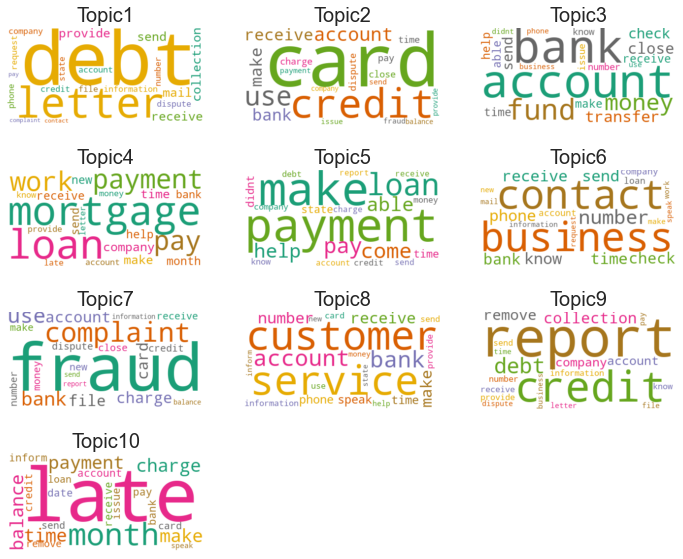

In [35]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [12, 10]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(4, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i], size=20)

plt.show()

In [36]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized,
                                    dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3983014022152906


### Tuning num_topics of LDA model

In [38]:
# Find the optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    calcualte the baseline coherence score
    
    trains multiple LDA models and provides the models and their corresponding coherece scores
    
    ------
    
    limit: max number of topics
    
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
                                                        start=4, limit=30, step=2)

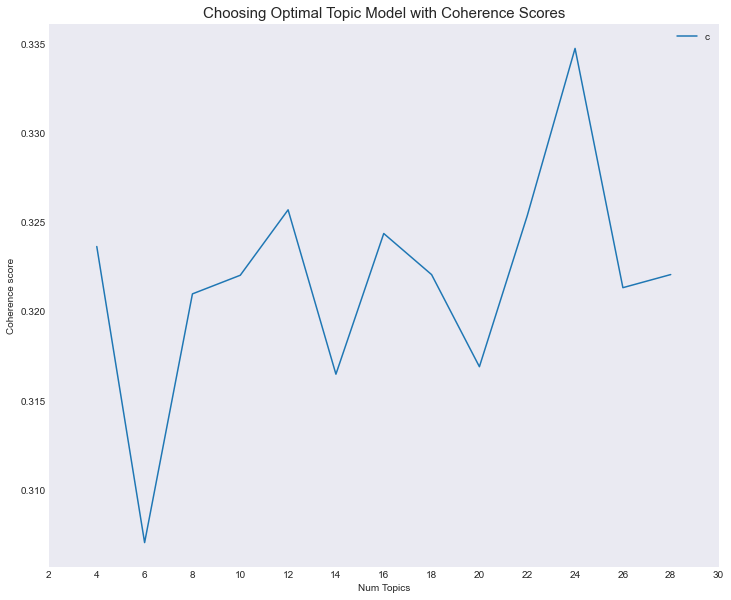

In [40]:
start=4; limit=30; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title('Choosing Optimal Topic Model with Coherence Scores', size=15)
plt.xticks(np.arange(2,32,step=2))
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.savefig("coherence_score.png")
plt.show()

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.3236
Num Topics = 6  has Coherence Value of 0.307
Num Topics = 8  has Coherence Value of 0.321
Num Topics = 10  has Coherence Value of 0.322
Num Topics = 12  has Coherence Value of 0.3257
Num Topics = 14  has Coherence Value of 0.3165
Num Topics = 16  has Coherence Value of 0.3244
Num Topics = 18  has Coherence Value of 0.3221
Num Topics = 20  has Coherence Value of 0.3169
Num Topics = 22  has Coherence Value of 0.3254
Num Topics = 24  has Coherence Value of 0.3347
Num Topics = 26  has Coherence Value of 0.3213
Num Topics = 28  has Coherence Value of 0.3221


In [42]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
#select the model and print the topics
# model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \
of {coherence_values[best_result_index]}''')

The 24 topics gives the highest coherence score of 0.3347334611220676


### Final Topic Model

In [54]:
# Final Model
final_model = models.LdaMulticore(corpus=corpus,
                               id2word=id2word,
                               num_topics=24,
                               random_state=100,
                               chunksize=100,
                               passes=10)

### Visualize Topics

In [55]:
#visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(final_model, corpus, id2word)

pyLDAvis.display(vis)

In [56]:
pyLDAvis.save_html(vis, "lda.html")

## Finding the dominant topic in each document

In [57]:
# Determine what topic a given document is about
def format_topics_sentences(ldamodel=final_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [58]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=final_model, corpus=corpus, texts=data)

In [59]:
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,0
0,13.0,0.3283,"credit, report, account, collection, debt, company, remove, agency, bill, owe",in xxxx i started receiving mail and phone calls from lvnv funding about a debt from xxxx xxxx for {$100000} i disputed this information several times in writing telling them i dont owe this debt and to send me verification or delete this information off my credit report lvnv keep sending me a bill as valid reason for them to report this fraudulent information on my credit report in xxxx i starting receiving more calls and mail about this debt this time it was resurgent capital services telling me i need to pay them because it was in pre legal status and i am getting sued they called several times a day interrupting me while i was at work i disputed with them as well but received mail correspondence from lvnv with yet another bill as verification in xxxxxxxx i started to receive mail and calls from now xxxx xxxx xxxx about this same debt i have been getting harnessed by lvnv and its related companies for months about a debt that isnt mine lvnv couldnt provide me with a contract with a signature like i requested so i am being attacked by 3 different companies about the same debt that is hurting my credit file and coasting me additional money on xxxxxxxx i decide to call resurgent and resolve this debt because of the damage it is doing to my credit i explained to the representative that this wasnt my debt however i wish to resolve it i asked about a settlement and they offered 20 % i said that was too much the representative pulled my credit without my permission and told me i could afford it and quoted every credit card as well as my children names off my credit report she told me my credit lines and who i was an authorized user on what card and everything i dont feel its fair that lvnv funding is allowed to report fraudulent unverified information on my credit file i dont feel that lvnv funding should be allowed to harass me through all of their different companies for the same debt i dont feel as the representative had a right to access my credit file without my permission and tell me that i can afford to pay a debt that i told her i wasnt capable of paying in full i was treated very badly and i feel my privacy has been invaded
1,22.0,0.4663,"bank, get, account, check, card, customer, money, time, make, back",in xxxx2019 i received a phone call from xxxx xxxx stating she is going to handle my case from xxxx xxxx she told me that and hung up i didnt ask her anything or go into depth about anything i received a letter today dated xxxxxxxx thanking me for speaking with her and that i requested for my card to be reopened neither are true and she lied about a letter being sent to me xxxx wrote a letter that was basically a lie she called to inform me she was taking the case and hung up nothing else was said or asked
2,19.0,0.4755,"send, email, receive, back, get, return, money, refund, order, phone",on tuesday xxxx2019 i received a vm from xxxx xxxx xxxx i returned the call and spoke with xxxx at xxxx i requested validation of my debt and he responded by saying it was already sent i again requested for the validation to be mailed to my address and i verified my address xxxx said he would email it i said no email i prefer by mail on xxxx2019 i received the correspondence via email when i strictly requested by mail then i asked for no more calls as i would take care of the balance after reviewing the validation today xxxx2019 my brother sent me a message via messenger saying xxxx called him asking for information about me i already asked for no more calls so i am not sure why they continue to harass me and my family
3,9.0,0.3333,"card, charge, fraud, credit, make, fraudulent, account, purchase, use, report",i have bank of america debit cardi travelled to xxxx on xxxxxxxx and returned back to usa on xxxxxxxx i have been using by debit card in xxxx ( informed bank before travel about that and

In [74]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.3283,"credit, report, account, collection, debt, company, remove, agency, bill, owe",in xxxx i started receiving mail and phone calls from lvnv funding about a debt from xxxx xxxx for {$100000} i disputed this information several times in writing telling them i dont owe this debt and to send me verification or delete this information off my credit report lvnv keep sending me a bill as valid reason for them to report this fraudulent information on my credit report in xxxx i starting receiving more calls and mail about this debt this time it was resurgent capital services telling me i need to pay them because it was in pre legal status and i am getting sued they called several times a day interrupting me while i was at work i disputed with them as well but received mail correspondence from lvnv with yet another bill as verification in xxxxxxxx i started to receive mail and calls from now xxxx xxxx xxxx about this same debt i have been getting harnessed by lvnv and its related companies for months about a debt that isnt mine lvnv couldnt provide me with a contract with a signature like i requested so i am being attacked by 3 different companies about the same debt that is hurting my credit file and coasting me additional money on xxxxxxxx i decide to call resurgent and resolve this debt because of the damage it is doing to my credit i explained to the representative that this wasnt my debt however i wish to resolve it i asked about a settlement and they offered 20 % i said that was too much the representative pulled my credit without my permission and told me i could afford it and quoted every credit card as well as my children names off my credit report she told me my credit lines and who i was an authorized user on what card and everything i dont feel its fair that lvnv funding is allowed to report fraudulent unverified information on my credit file i dont feel that lvnv funding should be allowed to harass me through all of their different companies for the same debt i dont feel as the representative had a right to access my credit file without my permission and tell me that i can afford to pay a debt that i told her i wasnt capable of paying in full i was treated very badly and i feel my privacy has been invaded
1,1,22.0,0.4663,"bank, get, account, check, card, customer, money, time, make, back",in xxxx2019 i received a phone call from xxxx xxxx stating she is going to handle my case from xxxx xxxx she told me that and hung up i didnt ask her anything or go into depth about anything i received a letter today dated xxxxxxxx thanking me for speaking with her and that i requested for my card to be reopened neither are true and she lied about a letter being sent to me xxxx wrote a letter that was basically a lie she called to inform me she was taking the case and hung up nothing else was said or asked
2,2,19.0,0.4755,"send, email, receive, back, get, return, money, refund, order, phone",on tuesday xxxx2019 i received a vm from xxxx xxxx xxxx i returned the call and spoke with xxxx at xxxx i requested validation of my debt and he responded by saying it was already sent i again requested for the validation to be mailed to my address and i verified my address xxxx said he would email it i said no email i prefer by mail on xxxx2019 i received the correspondence via email when i strictly requested by mail then i asked for no more calls as i would take care of the balance after reviewing the validation today xxxx2019 my brother sent me a message via messenger saying xxxx called him asking for information about me i already asked for no more calls so i am not sure why they continue to harass me and my family
3,3,9.0,0.3333,"card, charge, fraud, credit, make, fraudulent, account, purchase, use, report",i have bank of america debit cardi travelled to xxxx on xxxxxxxx and returned back to usa on xxxxxxxx i have been using by debit card in xxxx ( informed bank before tra

## Find the most representative document for each topic

In [62]:
# Group top 5 doc under each topic
sent_topics_sorted_df = pd.DataFrame()

sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted_df = pd.concat([sent_topics_sorted_df, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted_df.columns = ['Document_No', 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted_df.head(10)

,Document_No,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,6480,0.0,0.9617,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx2020 my bill for xxxx dollars did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
1,5726,0.0,0.9617,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx xxxx my bill for xxxx dollars did not go through when it was on auto-bill i reached to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a loan because of this mark on my credit and the company will not help me with this unfair situation
2,4262,0.0,0.9601,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx 2020 my bill did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
3,4735,0.0,0.9601,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx2017 my bill did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
4,6514,0.0,0.9601,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx2020 my bill did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
5,4916,1.0,0.9263,"court, attorney, file, settlement, judge, state, case, lawyer, make, lawsuit",called claiming they were going to sue us over a xxxx year old debt in the amount of xxxx which we do not believe exist states they will settle for xxxx other wise will go to court and garnish wages and sue us
6,7425,1.0,0.8193,"court, attorney, file, settlement, judge, state, case, lawyer, make, lawsuit",they rtreatened and sued me for the amount owed even thou the debt it not valid it is old the lawyers they hired are very rude and my payments never go through
7,7337,1.0,0.8191,"court, attorney, file, settlement, judge, state, case, lawyer, make, lawsuit",they rtreatened and sued me for the amount owed even thou the debt it not valid it is old the lawyers they hired are very rude and my payments never go through
8,3574,1.0,0.7920,"court, attorney, file, settlement, judge, state, case, lawyer, make, lawsuit",in xxxx i received a postcard stating that an order of default was entered on xxxx by a midland funding llc i went and filled a notice of motion with the circuit court of xxxx xxxx illinois i had proof that this xxxx credit card with a {$100000} limit had indeed been paid the judge told me that this was not the hearing for that matter midland funding purchased this alleged debt from xxxx xxxx the problem is i don't owe this debt i have email confirmations that prove my payments i work as a substitute teacher which is considered part-time in xxxx midland funding was allowed to garnish my paychecks if they are more than {$74000} sometimes more than {$20000} a paycheck i h

In [63]:
sent_topics_sorted_df[['Topic_Num','Keywords', 'Text']]

,Topic_Num,Keywords,Text
0,0.0,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx2020 my bill for xxxx dollars did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
1,0.0,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx xxxx my bill for xxxx dollars did not go through when it was on auto-bill i reached to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a loan because of this mark on my credit and the company will not help me with this unfair situation
2,0.0,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx 2020 my bill did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
3,0.0,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx2017 my bill did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
4,0.0,"interest, rate, high, low, auto, company, payment, bill, reject, help",on xxxx2020 my bill did not go through when it was on auto-bill i reached out to the company and they said that they saw the payment try to come out of the bank but it was rejected they never notified me of the rejection and gave me this late payment i now can not get a mortgage because of this mark on my credit and the company will not help me with this unfair situation
...,...,...,...
115,23.0,"account, bank, fund, receive, deposit, transfer, check, money, business, provide",i was contacted by xxxx xxxx ( xxxx ) about a new trading strategy that is being tested he gained my trust since it was a name well recognized by myself via the xxxx xxxx xxxx xxxx i was subscribing to xxxx xxxx had business suspended activity and when the services returned xxxx xxxx was gone he introduced me to the strategy and solicited to open a trading account with xxxx via provided link xxxx xxxx xxxx encouraged by his successes i transferred xxxx to fund my account these funds were wired from my xxxx account to their designated bank in the us via llc companies after few successful trades i received a notice from degiro that i am tagged as a day trader and my account will be suspended for 90 days unless i deposit more money over {$2500000} ( see below ) xxxx confirmed that and solicited more money to be transferred to see bigger returns i cashed out my iras and transferred an additional xxxx xxxx xxxx xxxx and xxxx ( see below original deposit instructions from xxxx ) xxxx xxxx xxxx acct xxxx account name xxxx xxxx bank address xxxx xxxx xxxx xxxx xxxx xxxx xxxx caxxxx united states {$1000000} xxxx xxxx xxxx acct xxxx account name xxxx xxxx bank address xxxx xxxx xxxx xxxx xxxx xxxx xxxx caxxxx united states {$1500000} xxxx xxxx xxxx xxxx acct xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx ma xxxx {$1800000} xxxx xxxx xxxx xxxx ny-xxxx acct xxxxxxxx xxxx xxxx xxxxxxxx xxxx xxxx xxxx xxxx pa xxxx {$4000000} xxxx chase bank na acct xxxx xxxx xxxx xxxx xxxx fl xxxx {$3900000} xxxx chase bank na-xxxx acct xxxx xxxx xxxx xxxx bank address xxxx xxxx xxxx xxxx x

In [64]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_dominant_topic[['Dominant_Topic', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"credit, report, account, collection, debt, company, remove, agency, bill, owe",30.0,0.0038
1.0,22.0,"bank, get, account, check, card, customer, money, time, make, back",55.0,0.0070
2.0,19.0,"send, email, receive, back, get, return, money, refund, order, phone",33.0,0.0042
3.0,9.0,"card, charge, fraud, credit, make, fraudulent, account, purchase, use, report",601.0,0.0766
4.0,21.0,"account, bank, money, transaction, paypal, close, use, open, access, america",211.0,0.0269
